# Robot Localisation using a Particle Filter
***
# Table of Contents
1.  [Setup](#Setup)
2.  [Setting up the Environment](#Setting-up-the-Environment)
3.  [Initializing the Robot](#Initializing-the-Robot)
4.  [Sense Function](#Sense-Function)
5.  [Move Function](#Move-Function)

# Setup

For this assignment I heavily used my work from ex 24 and previous exercises. To better present my work, I removed the
oop aspect of having a robot class and decided to make my robot in the form of a global python dictionary, consequently,
the function classes now access the robot/particles by reference. This allowed me to split my code in several cells
making it easier to explain and mark which part of the assignment where.

For this I will mark each code cell by a quoted text, featuring which exercises where tackled.

Example:

> a(i), a(ii)

```
def sense(rob):
    .
    .
    .
```

Some code cells will have an md cell above it with the sub heading **Code Explanation** and some code cells will have one
beneath them with the sub heading **Comments**. These md cells will have code explanations and comments about the code
and/or results.

I am using python 3.7.

In [1]:
from math import pi, sqrt, cos, sin, atan2, tan, exp
from random import random, gauss
import matplotlib.pyplot as plt
%matplotlib inline

## Comments

Pi and a number of functions from the standard math and random libraries are required for this assignment.

I will be using matplotlib to draw the environment to better visualize and explain what is going on.

# Setting up the Environment

In this step I initialise the landmark locations and and world size.

## Code Explanation
I also code in a drawEnv function which is able to draw the environment boundaries as blue lines and the landmarks as
red circles.

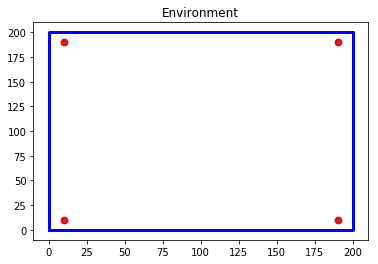

In [2]:
LANDMARKS  = [[10, 10], [190, 190], [10, 190], [190, 10]]
WORLD_SIZE = 200

def drawEnv():
    x_landmark = [10, 190, 10, 190]
    y_landmark = [10, 190, 190, 10]
    # Draw point based on above x, y axis values.
    plt.scatter(x_landmark, y_landmark, s=8, edgecolors="red", linewidths=5)
    x_bounds = [0, 200, 200, 0, 0]
    # List to hold y values.
    y_bounds = [0, 0, 200, 200, 0]
    # Plot the environment bound
    plt.plot(x_bounds, y_bounds, linewidth=3, color='b')
    plt.title("Environment")
drawEnv()
plt.show()

# Initializing the Robot

## Code Explanation

In this step I initialise the robot giving it a random point in the boundary and a random orientation. I also initialise
the robots length, and a number of noise values as instructed by the assignment.

In [3]:
MAX_STEERING_ANGLE = pi / 4 # r
BEARING_NOISE_VAR, STEERING_NOISE_VAR, DISTANCE_NOISE_VAR = (0.1, 0.1, 5)

ROBOT_LENGTH = 10

robot = {
            "front_x": random() * WORLD_SIZE,
            "front_y": random() * WORLD_SIZE,
            "orientation": random() * 2 * pi,
            "steering": 0#-MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }

## Comments

At this stage I decided to initialise the steering angle at 0 so that I can properly test the move function later on.

## Code Explanation

Here I update drawEnv to now include a passed robot when drawing the environment. The robot can be drawn as either a red
or cyan arrow, the direction of the arrow being its orientation.

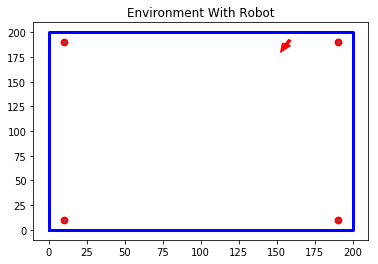

In [4]:
def drawEnvWithBot(rob, red=True):
    drawEnv()
    plt.title("Environment With Robot")
    if red:
        colour = 'r'
    else:
        colour = 'c'
    plt.arrow(rob['front_x'], rob['front_y'], cos(rob['orientation']) * 5, sin(rob['orientation']) * 5, width=2, color=colour)
drawEnvWithBot(robot)
plt.show()

## Comments

The cyan and red colour will help us differentiate between the robot and the particles later on.

# Sense Function

I split this part into two; first the robot senses without having the noise added in, to make sure the function works,
then I add the noise in and check the difference.

> a(i), a(ii)

## Code Explanation

The getAngle function returns the angle between two points.

In [5]:
def getAngle(fromX,fromY,toX,toY):
    deltaX = fromX - toX
    deltaY = fromY - toY
    return atan2(deltaY, deltaX)

## Code Explanation

Sense uses the getAngle function to get the angle between the robot and the four landmarks. This reading ```z``` is
appended to ```Z``` a list.

I also get the euclidean distance between these two points and append the x, y points to ```x2``` and ```y2```, both
lists. This will allow me to plot the sensor readings as lines using matplotlib.

In [6]:
x2 = []
y2 = []

def sense(rob):
    Z = []
    for landmark in LANDMARKS:
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        x2.append(rob['front_x'] + dist * -cos(z))
        y2.append(rob['front_y'] + dist * -sin(z))
        Z.append(z)

    return Z

## Code Explanation

Here I add the drawing of the sensor readings by plotting orange lines coming out of the robot, and hopefulyl landing on
the landmarks.

In [7]:
def drawEnvWithSensorReadings(rob):
    line_x = []
    for x in x2:
        line_x.append(rob['front_x'])
        line_x.append(x)

    line_y = []
    for y in y2:
        line_y.append(rob['front_y'])
        line_y.append(y)

    plt.plot(line_x, line_y, linewidth=1, color='orange')
    drawEnvWithBot(rob)

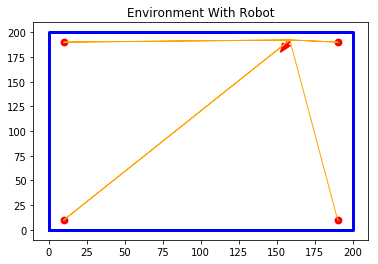

In [8]:
s = sense(robot)
drawEnvWithSensorReadings(robot)
plt.show()

## Comments

Great, the robot was able to perfectly sense where the landmarks are.


## Code Explanation

Now its time to add noise to the angle and distance readings. This is done by adding a random number from gaussian
distribution with signma = BEARING_NOISE_VAR for the bearing readings and sigma = DISTANCE_NOISE_VAR for the distance
readings.

In [9]:
def sense(rob):
    Z = []
    for landmark in LANDMARKS:
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        z += gauss(0, BEARING_NOISE_VAR)
        dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        x2.append(rob['front_x'] + dist * -cos(z) + gauss(0, DISTANCE_NOISE_VAR))
        y2.append(rob['front_y'] + dist * -sin(z) + gauss(0, DISTANCE_NOISE_VAR))
        Z.append(z)

    return Z

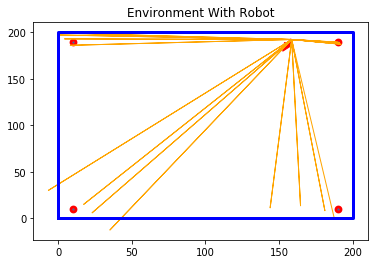

In [10]:
x2 = []
y2 = []

for _ in range(4):
    s = sense(robot)
drawEnvWithSensorReadings(robot)
plt.show()

## Comments

Now that noise is added each sensor reading is different from the other with varying bearing and distance readings. This
confirms that the sense function is working as intended.


# Move Function

For the move function I opted to only present its final version since it is quite longer than the sense function. Also
most of the code explanation will be done via inline comments for the function itself.

> b(i), b(ii), b(iii), b(iv), b(v)

## Code Explanation

With set_pos I am able to make sure that if the robot moves out of bounds I can fix it by flipping its angle and placing
it within bounds.

In [11]:
def set_pos(new_x, new_y, new_orientation, new_steering):
    if new_x < 0 or new_x >= WORLD_SIZE:
        new_x = 0 if new_x < 0 else WORLD_SIZE
        new_orientation = - pi
        new_orientation %= (2 * pi)
    if new_y < 0 or new_y >= WORLD_SIZE:
        new_y = 0 if new_y < 0 else WORLD_SIZE
        new_orientation = - pi
        new_orientation %= (2 * pi)
    if new_orientation < 0 or new_orientation >= 2 * pi:
        raise ValueError('Orientation must be in [0..2pi]')
    if new_steering < -MAX_STEERING_ANGLE or new_steering > MAX_STEERING_ANGLE:
        raise ValueError('Steering must be in [-pi/4..pi/4]')
    return float(new_x), float(new_y), float(new_orientation), float(new_steering)

In [12]:
def move(rob, steer_angle, distance):
    # b(i)
    # Here I make sure that the passed steer_angle and distance are within bounds i.e. inside the maximum steer angle,
    # and a forward direction distance (no reversing)
    if steer_angle < -MAX_STEERING_ANGLE or steer_angle > MAX_STEERING_ANGLE:
        raise ValueError('Robot can only steer in [-pi/4..pi/4]')
    if distance < 0:
        raise ValueError('Robot can only move forward')

    # b(ii)
    # Get a new steer angle by adding noise to the input
    steering = steer_angle + gauss(0, STEERING_NOISE_VAR)
    # make sure it is within bounds
    # using % doesnt work here so I have to check which bound it potentially reached manually
    steering = MAX_STEERING_ANGLE if steering > MAX_STEERING_ANGLE else steering
    steering = -MAX_STEERING_ANGLE if steering < MAX_STEERING_ANGLE else steering
    #steering %= MAX_STEERING_ANGLE

    # Get the new distance by adding noise to the input
    dist = distance + gauss(0.0, DISTANCE_NOISE_VAR)

    # b(iii)
    # Get the turn angle
    turn = (dist/ROBOT_LENGTH) * tan(steering)

    # b(iv)
    # decide whether to approximate straight line motion or use the bicycle model
    if turn > 0.001 or turn < -0.001:
        # b(v)
        # Here I use the bicycle model to get a new location for the robot
        r = tan((pi/2) - steering) * ROBOT_LENGTH

        Cx = rob['front_x'] - (r * sin(rob['orientation']))
        Cy = rob['front_y'] + (r * cos(rob['orientation']))

        x = Cx + (r * sin(rob['orientation'] + turn))
        y = Cy - (r * cos(rob['orientation'] + turn))

        orientation = (rob['orientation'] + turn)
        orientation %=( 2 * pi)

    else:
        # Straight line motion
        x = rob['front_x'] + (cos(rob['orientation']) * dist)
        y = rob['front_y'] + (sin(rob['orientation']) * dist)
        x %= WORLD_SIZE
        y %= WORLD_SIZE
        orientation = (rob['orientation'] + steering)
        orientation %= (2 * pi)

    rob['front_x'], rob['front_y'], rob['orientation'], rob['steering'] = set_pos(x, y, orientation, steering)
    return rob

## Code Explanation

Here I draw the robot before moving, and then again after the move.

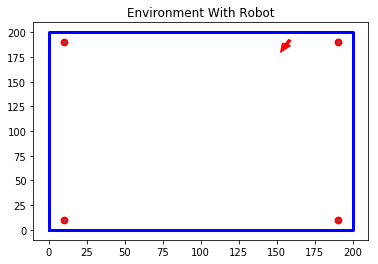

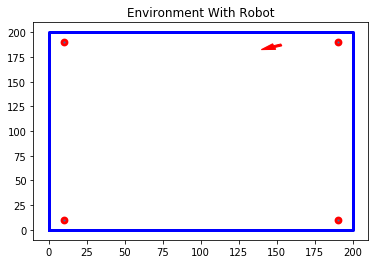

In [13]:
drawEnvWithBot(robot)
plt.show()

robot = move(robot, 0, 10)

drawEnvWithBot(robot)
plt.show()

## Comments

While expected to move in a straight line I found that this will almost never happen due to the large noise assigned to the sensors. This is possible since the noise for the steering is 0.1 while the treshold for straight line movement is 0.001.

It is also important to note that from this stage onward, the robot's location is approximated and not true.

# Particle Filter

For this final segment of the assignment a number of functions where used.

## Code Explanation

These two functions below are used to give us the probability that a measurement taken is correct. This will be used to
weigh the particles.

> c(ii)

In [14]:
def Gaussian(mu, sigma, x):
    # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

def measurement_prob(rob, measurement):
    # calculates how likely a measurement should be
    prob = 1.0
    for j, landmark in enumerate(LANDMARKS):
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        prob *= Gaussian(z, BEARING_NOISE_VAR, measurement[j])
    return prob

## Code Explanation

Using the evaulate function I can get the average error between the robot passed and the particles passed.

In [15]:
def evaluate(rob, particles):
    sum = 0.0
    for p in particles: # calculate mean error
        dx = (p['front_x'] - rob['front_x'] + (WORLD_SIZE/2.0)) % (WORLD_SIZE - (WORLD_SIZE/2.0))
        dy = (p['front_y'] - rob['front_y'] + (WORLD_SIZE/2.0)) % (WORLD_SIZE - (WORLD_SIZE/2.0))
        err = sqrt((dx * dx) + (dy * dy))
        sum += err
    return sum / float(len(particles))

## Comments

Now that I have all my tools ready I can initialise the particles in the environment as well as a new robot with random
steering.

## Code Explanation
Apart from re-initialising the robot and setting up for the particle filter I also draw the robot in the environment as
well as the particles. From now on the robot will be a red arrow and the particles cyan arrows.

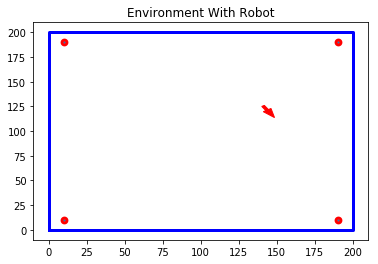

Mean error at start  76.89461154016273
8.958579695509371 38.545710921026476 0.24691356712846688 0.5908524682336278
35.039030937333784 101.30671321250182 3.0757438455987707 -0.7174157809028054
132.52155019787898 49.41134930080779 2.58253299398372 -0.34406418524803006
147.20648462370525 5.680353539407879 0.4499904712179498 -0.0697649424285871
176.6080151059963 30.989089808040028 2.5643757637806117 -0.6457252658676247
156.16581947089742 165.059084686839 0.30179084970090786 -0.1665151003254609


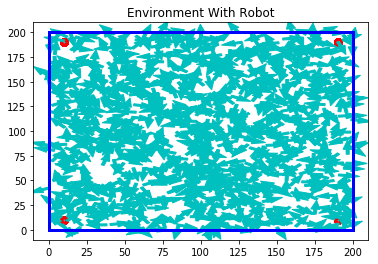

In [16]:
N = 500
epoch = 5

robot = {
            "front_x": random() * WORLD_SIZE,
            "front_y": random() * WORLD_SIZE,
            "orientation": random() * 2 * pi,
            "steering": -MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }

drawEnvWithBot(robot)
plt.show()

p = []
for i in range(N):
    r = {
            "front_x": random() * WORLD_SIZE,
            "front_y": random() * WORLD_SIZE,
            "orientation": random() * 2 * pi,
            "steering": -MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }
    p.append(r)

print( 'Mean error at start ', evaluate(robot, p))
for i, _p in enumerate(p):
    print(_p['front_x'], _p['front_y'], _p['orientation'], _p['steering'])
    if i == 5:
        break
for _p in p:
    drawEnvWithBot(_p, False)
plt.show()

## Comments

The particle plot clearly shows that they where evenly distributed throughout the environment.

In [17]:
for _ in range(epoch):
    robot = move(robot, 0.1, 5.0)

    Z = sense(robot)

    p2 = []
    for _p in p:
        p2.append(move(_p, 0.1, 5.0))
    p = p2

    w = []
    for _p in p:
        w.append(measurement_prob(_p, Z))
    p3 = []

    index = int(random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3

    print('Mean error',evaluate(robot, p))

Mean error 74.46178052672633
Mean error 93.08969036899676
Mean error 109.72889666975543
Mean error 24.556124433413274
Mean error 95.56119802099737


In [ ]:
for _p in p:
    drawEnvWithBot(_p, False)

drawEnvWithBot(robot)
plt.show()